<a href="https://colab.research.google.com/github/angeloken/Bangkit-Academy/blob/master/coffe_leaf_disease_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tqdm import tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.4.1
• Using TensorFlow Hub Version:  0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Not Found. Running on CPU


In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


# <b>Import Library Dependencies<b>

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

## <i>Mount Drive to Input Dataset<i>

Mount the drive which contain coffe leave rust and miner dataset.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/kohinoka/coffe_leave_disease.zip"

## Save the dataset to Colab

Unzip the the dataset and save it under '/tmp' directory. /tmp folder can be seen at the file section on the left window. 

In [ ]:
import os
import zipfile

local_zip = '/content/drive/My Drive/kohinoka/coffe_leave_disease_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

define the train and validation folder path using OS library

In [ ]:
base_dir = '/tmp/coffe_leave_disease_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# Directory with our training cat/dog pictures
train_miner_dir = os.path.join(train_dir, 'miner')
train_rust_dir = os.path.join(train_dir, 'rust')

# Directory with our validation cat/dog pictures
validation_miner_dir = os.path.join(validation_dir, 'miner')
validation_rust_dir = os.path.join(validation_dir, 'rust')

Several codes below could help you to see some parts of the dataset

In [ ]:
train_miner_fnames = os.listdir( train_miner_dir )
train_rust_fnames = os.listdir( train_rust_dir )

print(train_miner_fnames[:10])
print(train_rust_fnames[:10])

['bicho_mineiro146.jpg', 'bicho_mineiro218.jpg', 'bicho_mineiro137.jpg', 'bicho_mineiro101.jpg', 'bicho_mineiro85.jpg', 'bicho_mineiro229.jpg', 'bicho_mineiro208.jpg', 'bicho_mineiro186.jpg', 'bicho_mineiro122.jpg', 'bicho_mineiro36.jpg']
['name27.jpg', 'name9.jpg', 'name71.jpg', 'name118.jpg', 'name157.jpg', 'name113.jpg', 'name219.jpg', 'name213.jpg', 'name73.jpg', 'name65.jpg']


In [ ]:
print('total training miner images :', len(os.listdir(train_miner_dir ) ))
print('total training rust images :', len(os.listdir(train_rust_dir ) ))

print('total validation miner images :', len(os.listdir( validation_miner_dir ) ))
print('total validation rust images :', len(os.listdir( validation_rust_dir ) ))

total training miner images : 229
total training rust images : 256
total validation miner images : 28
total validation rust images : 29


In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

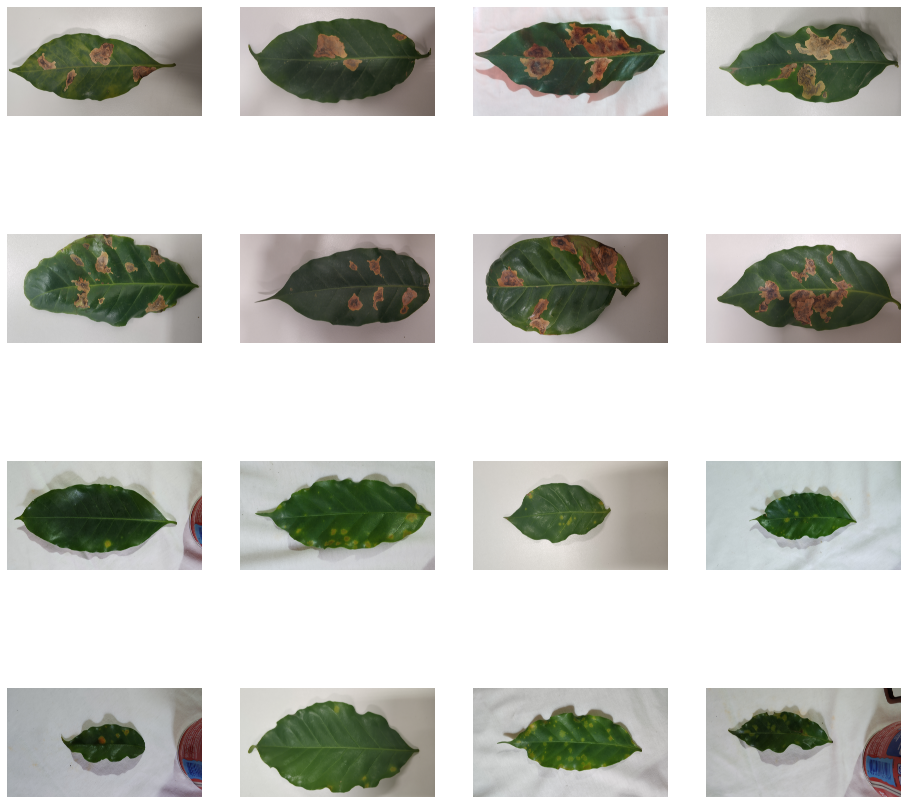

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_miner_pix = [os.path.join(train_miner_dir, fname) 
                for fname in train_miner_fnames[ pic_index-8:pic_index] 
               ]

next_rust_pix = [os.path.join(train_rust_dir, fname) 
                for fname in train_rust_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_miner_pix+next_rust_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [ ]:
inception = InceptionV3(input_shape= (224, 224, 3), weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [ ]:
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
pretrained_model = tf.keras.applications.MobileNet()
tf.saved_model.save(pretrained_model, '/tmp/saved_model/1/')